<a href="https://colab.research.google.com/github/VDliveson/Pneumonia-detection/blob/main/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia detection

---



In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                 title                                  size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  ------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                  Data Science Job Salaries               7KB  2022-06-15 08:59:12          18542        577  1.0              
nancyalaswad90/diamonds-prices                      Diamonds Prices                       711KB  2022-07-09 14:59:21           2164         94  1.0              
aravindas01/monkeypox-cases-countrywise-data        MonkeyPox Cases_Countrywise Data        6KB  2022-08-10 17:12:36            611         33  0.9117647        
faryarmemon/usa-housing-market-factors              U.S. Housing Market Factors            32KB  2022-08-03 02:19:31            479         33  1.0              
himanshunakrani/student-stud

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/sample_data/ --unzip

100% 2.29G/2.29G [00:51<00:00, 67.5MB/s]
100% 2.29G/2.29G [00:51<00:00, 48.3MB/s]


## Importing Libraries

In [ ]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
np.random.seed(22)

## Image loading and grayscale conversion

In [ ]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels


In [ ]:
norm_images, norm_labels = load_normal('sample_data/chest_xray/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('sample_data/chest_xray/train/PNEUMONIA/')

100%|██████████| 3875/3875 [00:32<00:00, 121.08it/s]


Making test and train variables

In [ ]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

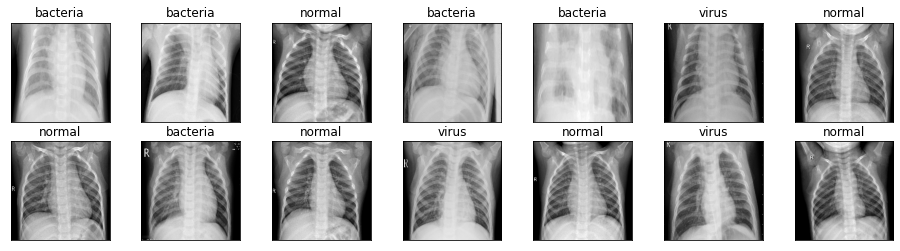

In [ ]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [ ]:
norm_images_test, norm_labels_test = load_normal('sample_data/chest_xray/chest_xray/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('sample_data/chest_xray/chest_xray/test/PNEUMONIA/')
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

100%|██████████| 390/390 [00:02<00:00, 137.43it/s]


In [ ]:
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)# Use this to load variables
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

In [ ]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

## Adding one-hot encoder

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)

In [ ]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

In [ ]:
y_train_one_hot

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

## Reshaping for adding color channel layer

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

## Data augmentation

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [ ]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size=32)

## Building CNN

In [ ]:
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

cnn = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit_generator(train_gen, epochs=30, 
          validation_data=(X_test, y_test_one_hot))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
163/163 [==============================] - 29s 111ms/step - loss: 9.6193 - acc: 0.5608 - val_loss: 1.1037 - val_acc: 0.4952
Epoch 2/30
163/163 [==============================] - 17s 103ms/step - loss: 0.6821 - acc: 0.7120 - val_loss: 0.6733 - val_acc: 0.7692
Epoch 3/30
163/163 [==============================] - 17s 102ms/step - loss: 0.6170 - acc: 0.7339 - val_loss: 0.6720 - val_acc: 0.7837
Epoch 4/30
163/163 [==============================] - 18s 111ms/step - loss: 0.6168 - acc: 0.7341 - val_loss: 0.6893 - val_acc: 0.7724
Epoch 5/30
163/163 [==============================] - 16s 101ms/step - loss: 0.5665 - acc: 0.7627 - val_loss: 0.6448 - val_acc: 0.8173
Epoch 6/30
163/163 [==============================] - 17s 106ms/step - loss: 0.5964 - acc: 0.7527 - val_loss: 0.8353 - val_acc: 0.7452
Epoch 7/30
163/163 [==============================] - 17s 101ms/step - loss: 0.5810 - acc: 0.7571 - val_loss: 0.7388 - val_acc: 0.7260
Epoch 8/30
163/163 [==============================] - 1

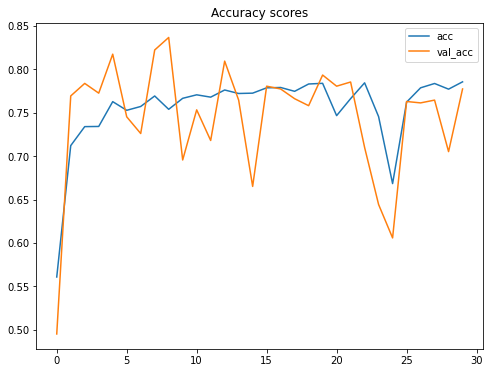

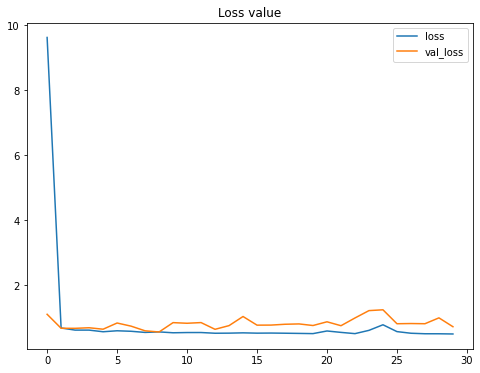

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Making Predictions

In [ ]:
predictions = model.predict(X_test)
predictions = one_hot_encoder.inverse_transform(predictions)

In [ ]:
cm = confusion_matrix(y_test, predictions)

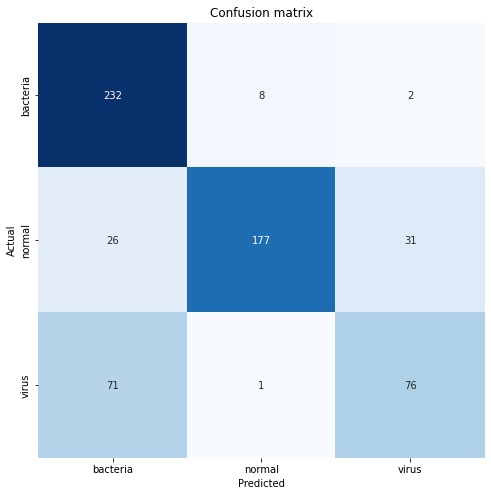

In [ ]:
classnames = ['bacteria', 'normal', 'virus']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()